In [24]:
from datasets import load_dataset
from g2p_en import G2p
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoTokenizer
from tqdm import tqdm

g2p = G2p()

generics_kb = load_dataset(
    'community-datasets/generics_kb', name='generics_kb_best', split='train')
ponyspeech_dataset = load_dataset(
    'synthbot/pony-speech', split='train')

tokenizer = AutoTokenizer.from_pretrained("therealvul/tokenizer_g2pen")
# Taken from the tokenizer config file
merges = ["H 0", "A H0", "H 1", "Y 1", "W 1", "I H0", "A E", "I H1", "AH0 N", "E R", "E H1", "AE 1", "A A", "A H1", "AA 1", "ER 0", "Y 0", "I Y0", "U W1", "D H", "A O", "A Y1", "I Y1", "E Y1", "AH0 L", "AO 1", "IH0 N", "O W1", "S T", "H H", "S H", "AA1 R", "DH AH0", "AO1 R", "AE1 N", "IH1 Z", "J H", "AH1 V", "T S", "H 2", "Y 2", "AH0N D", "T UW1", "IH0N G", "ER 1", "EH1 N", "SH AH0N", "C H", "AH0 T", "P R", "IH0 K", "AH0 M", "EH1 R", "Y UW1", "AH1 M", "T H", "HH AE1", "AH0 S", "A W1", "AH0N T", "W 0", "IH1 N", "ER0 Z", "AH0 D", "AH0 Z", "HHAE1 V", "EH1 L", "R IY0", "AE1 T", "K T", "E H2", "K S", "AA1 N", "F AO1R", "AH1 N", "L IY0", "EY1 SHAH0N", "M OW1", "U H1", "E Y2", "D Z", "A Y2", "S AH1M", "I H2", "AO1 L", "D IH0", "W IH1", "P L", "AH0 K", "W 2", "O W0", "T ER0", "G R", "L AY1", "T R", "S P", "AH0 B", "AH0L Z", "MOW1 ST", "EY1 N", "K AE1N", "F R", "IY0 Z", "M AH0N", "IH1 L", "DH AE1T", "AE 2", "AH0N S", "N D", "IH1 T", "AA1R T", "K AA1", "K R", "OW1 N", "AA 2", "IH0 V", "AH0 P", "O W2", "U W0", "AA1 L", "AH0T IY0", "IH0 Z", "ST R", "B IY1", "S K", "IH1N G", "EY2 T", "AH0 JH", "P AA1RT", "N Z", "EH1 K", "DH EH1R", "B R", "IY1 Z", "IY1 T", "AE1 Z", "AH0N Z", "V ER0", "WIH1 DH", "AH1 T", "B AY1", "EH1 T", "D R", "P AH0L", "OW1 L", "YUW1 Z", "W AY1", "AH0 F", "I Y2", "AE 0", "EH1 S", "EY1 T", "E H0", "EH1 M", "AO 2", "F L", "M EH1N", "AE1 K", "B L", "EH1 D", "P ER0", "IH1 R", "EH1 KT", "O Y1", "M Z", "IH1 F", "EH1 ST", "M EY1", "W IY1", "DH ER0", "CH ER0", "L Z", "A Y0", "K L", "D IY0", "G Z", "IH1 ST", "V AY1", "EH1R IY0", "UH1 R", "D ER0", "AE1 L", "AW1 T", "FR AH1M", "AH1 L", "M P", "N OW1", "AH0 ST", "T AY1", "P IY1", "AH0L IY0", "AE1 S", "W ER1", "IH1 S", "P S", "IH0 T", "IH2 N", "PR AA1", "IH0 L", "AA1 T", "S AY1", "K AH0M", "M IY1", "W AH1N", "W AO1", "AH0N TS", "PL AE1N", "S IY1", "SHAH0N Z", "UH1 D", "PIY1 PAH0L", "M AY1", "V Z", "MEH1N IY0", "AE1 M", "M AH0NT", "U W2", "AH0 W", "HH EH1L", "Y AH0L", "IH1 RIY0", "WAO1 TER0", "L OW1", "K AH0NT", "AH1 ST", "F IY1", "AH0M Z", "M AO1R", "EY1 S", "AE1 KT", "A H2", "D UW1", "AH0B AH0L", "KAA1 Z", "S EH1L", "AO1R T", "Y UW0", "L IY1", "TH R", "EH1N D", "UW1 D", "B AH1T", "S ER1", "N T", "S OW1", "F AY1", "AO1L S", "AH0 G", "N G", "DH EY1", "AH1 DHER0", "AO1LS OW0", "HH AY1", "L IH1", "AH1N G", "EH1N T", "W EY1", "AH0 V", "PR AH0D", "AW1 ER0", "IH0K AH0L", "SH AH0L", "AE1N AH0M", "DH AE1N", "HHAE1 Z", "EH1 V", "N AH0S", "AY1 T", "UW1 S", "R IH1", "K AE1", "L D", "V EH1RIY0", "R IY1", "OW1 Z", "S ER0", "IH0K S", "LAY1 K", "AY2 Z", "W EH1N", "P T", "K AH0N", "N UW1", "AW1 ND", "R IH0", "F ER0", "AO1 NG", "AE1N D", "EY1N JH", "AH0 TS", "EY1SHAH0N Z", "W AH1T", "S EH2", "DIH0 Z", "PLAE1N TS", "ER1 N", "TH IH1NG", "0 R", "S IH1", "GR OW1", "EH1N ER0", "AO2 R", "K W", "WIH1 CH", "AA1 KS", "S AH1", "IH2 Z", "AO1 F", "EY2T AH0D", "M AH1", "W EH1L", "AE1NAH0M AH0LZ", "IY1 V", "EH1 VER0", "HH YUW1", "T EY1", "IH0 MP", "S EY1", "JH AH1ST", "AY1 M", "AH1 P", "K AH1M", "EH2 RIY0", "IH1 SHAH0N", "IY1 N", "OW1 T", "B AA1", "D IH1F", "IH1 K", "B IH0K", "B IH0", "AW1 N", "S M", "EY1 Z", "M AH0T", "IH0 D", "K IH0NG", "W AA1", "TAY1 M", "HHYUW1 MAH0N", "B ER1", "HH IY1", "DH IH1S", "AE1N G", "IH1 V", "F UW1D"]

def phonemize(text):
    spl = text.split()
    l = []
    for s in spl:
        arpabet_string = ''.join(g2p(s))
        l.append(arpabet_string)
    return ' '.join(l)

ignore_tokens = set(['[UNK]', '[PAD]', '[CLS]', '[SEP]', '[MASK]'])
ignore_token_ids = set(tokenizer.vocab[x] for x in ignore_tokens)

Resolving data files:   0%|          | 0/31 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/31 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/30 [00:00<?, ?it/s]

In [4]:
from collections import defaultdict

dataset_token_counts = {index: 0 for index in tokenizer.vocab.values()}

for text in tqdm(ponyspeech_dataset['transcription']):
    encoding = tokenizer.encode(phonemize(text))
    for index in encoding:
        dataset_token_counts[index] += 1

100%|███████████████████████████████████| 64783/64783 [00:51<00:00, 1253.21it/s]


In [5]:
n = 240000
generic_token_counts = {index: 0 for index in tokenizer.vocab.values()}

for test_text in tqdm(generics_kb.shuffle().select(range(n))['generic_sentence']):
    encoding = tokenizer.encode(phonemize(test_text))
    for index in encoding:
        generic_token_counts[index] += 1

100%|██████████████████████████████████| 240000/240000 [04:26<00:00, 902.20it/s]


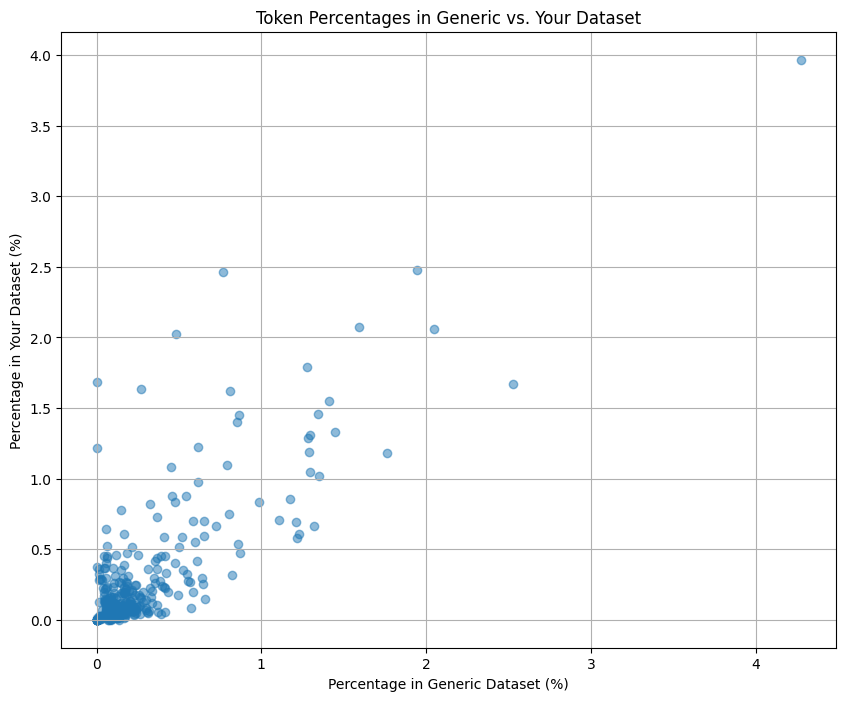

In [14]:
# Prepare data for scatter plot

# Map token IDs to tokens
id_to_token = {index: token for token, index in tokenizer.vocab.items()}

# Calculate Total Tokens and Percentages in Generic Dataset
total_generic_tokens = sum(generic_token_counts.values())
generic_token_percentages = {
    token_id: (count / total_generic_tokens) * 100
    for token_id, count in generic_token_counts.items()
}

# Optional: Calculate Total Tokens and Percentages in Your Dataset
total_dataset_tokens = sum(dataset_token_counts.values())
dataset_token_percentages = {
    token_id: (count / total_dataset_tokens) * 100
    for token_id, count in dataset_token_counts.items()
}

all_tokens = set(generic_token_percentages.keys()).union(dataset_token_percentages.keys()) - ignore_tokens
token_list = [id_to_token[token_id] for token_id in all_tokens]
generic_percentages = [generic_token_percentages.get(token_id, 0) for token_id in all_tokens]
dataset_percentages = [dataset_token_percentages.get(token_id, 0) for token_id in all_tokens]

# Scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(generic_percentages, dataset_percentages, alpha=0.5)
plt.xlabel('Percentage in Generic Dataset (%)')
plt.ylabel('Percentage in Your Dataset (%)')
plt.title('Token Percentages in Generic vs. Your Dataset')
plt.grid(True)
plt.show()


67


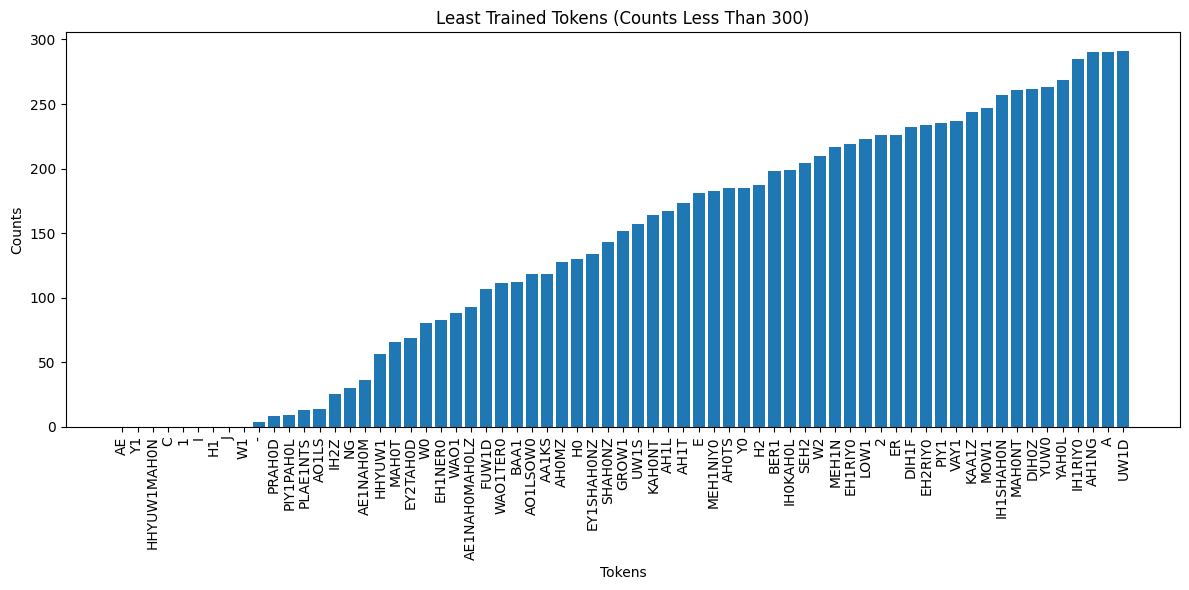

In [19]:
# Get least trained tokens (tokens with counts less than 300)
poorly_trained = sorted((item for item in dataset_token_counts.items() if item[1] < 300 and item[0] not in ignore_token_ids), key=lambda x: x[1])

# Print the number of poorly trained tokens
print(len(poorly_trained))

# Now, let's visualize the poorly trained tokens

# Extract tokens and counts
tokens = [id_to_token[p[0]] for p in poorly_trained]
counts = [p[1] for p in poorly_trained]

# Optionally, limit the number of tokens to display
# For example, display only the top 50 poorly trained tokens
top_n = 100
tokens = tokens[:top_n]
counts = counts[:top_n]

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(tokens, counts)
plt.xlabel('Tokens')
plt.ylabel('Counts')
plt.title('Least Trained Tokens (Counts Less Than 300)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


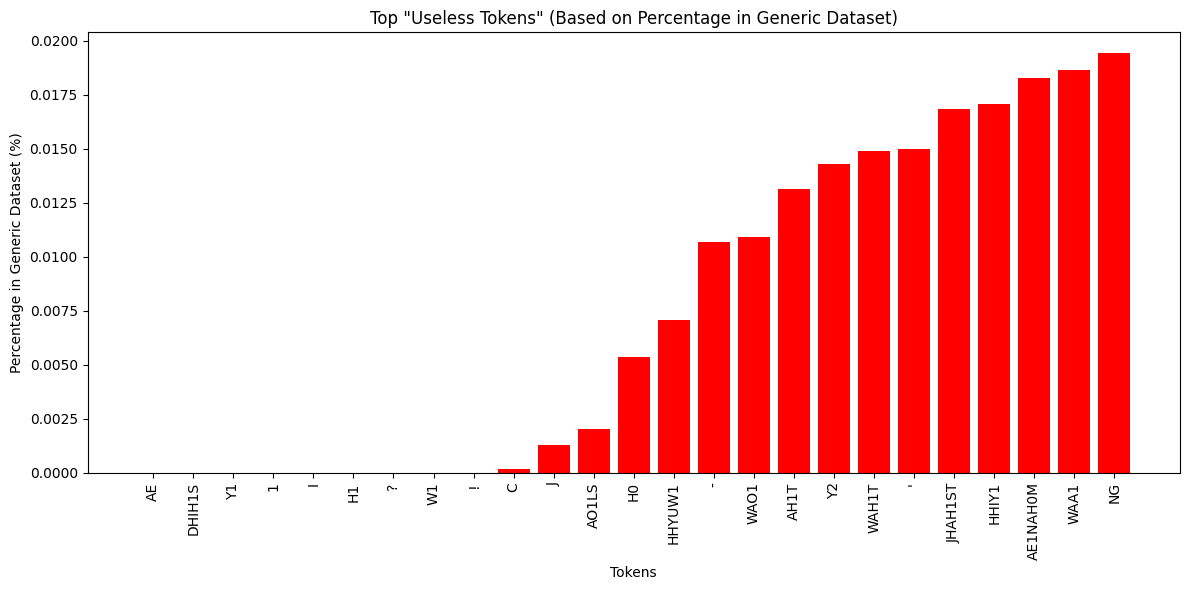

In [21]:
# Assuming 'dataset_token_counts', 'generic_token_counts', and 'id_to_token' are already defined

# Step 1: Calculate Total Tokens and Percentages in Generic Dataset
total_generic_tokens = sum(generic_token_counts.values())
generic_token_percentages = {
    token_id: (count / total_generic_tokens) * 100
    for token_id, count in generic_token_counts.items()
}

# Optional: Calculate Total Tokens and Percentages in Your Dataset
total_dataset_tokens = sum(dataset_token_counts.values())
dataset_token_percentages = {
    token_id: (count / total_dataset_tokens) * 100
    for token_id, count in dataset_token_counts.items()
}

# Step 2: Define Thresholds Based on Percentages
useless_percentage_threshold = 0.02  # Tokens less than 0.01% are considered 'useless'
common_percentage_threshold = 0.1    # Tokens more than 0.1% are considered 'common' in generic dataset

# Step 3: Identify 'Useless Tokens'
useless_tokens = {
    token_id: percentage
    for token_id, percentage in generic_token_percentages.items()
    if percentage < useless_percentage_threshold and token_id not in ignore_token_ids
}

# Step 4: Identify 'Poorly Trained Tokens'
# Tokens that are common in generic but underrepresented in your dataset

# Define a percentage threshold for 'underrepresented' in your dataset
dataset_underrepresented_threshold = 200  # Tokens that appear less than 200 times in your dataset

poorly_trained_tokens = {
    token_id: (generic_percentage, dataset_token_percentages.get(token_id, 0))
    for token_id, generic_percentage in generic_token_percentages.items()
    if generic_percentage > common_percentage_threshold
       and dataset_token_counts.get(token_id, 0) < dataset_underrepresented_threshold and token_id not in ignore_token_ids
}

# Step 5: Visualization

## Visualize 'Useless Tokens'

# Prepare data for visualization
tokens_useless = [id_to_token[token_id] for token_id in useless_tokens.keys()]
percentages_useless = list(useless_tokens.values())

# Sort tokens by percentages ascending
tokens_percentages_useless = sorted(zip(tokens_useless, percentages_useless), key=lambda x: x[1])
tokens_useless, percentages_useless = zip(*tokens_percentages_useless)

# Limit number of tokens for visualization
top_n_useless = 50  # Adjust as needed
tokens_useless = tokens_useless[:top_n_useless]
percentages_useless = percentages_useless[:top_n_useless]

# Plotting 'Useless Tokens'
plt.figure(figsize=(12, 6))
plt.bar(tokens_useless, percentages_useless, color='red')
plt.xlabel('Tokens')
plt.ylabel('Percentage in Generic Dataset (%)')
plt.title(f'Top "Useless Tokens" (Based on Percentage in Generic Dataset)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

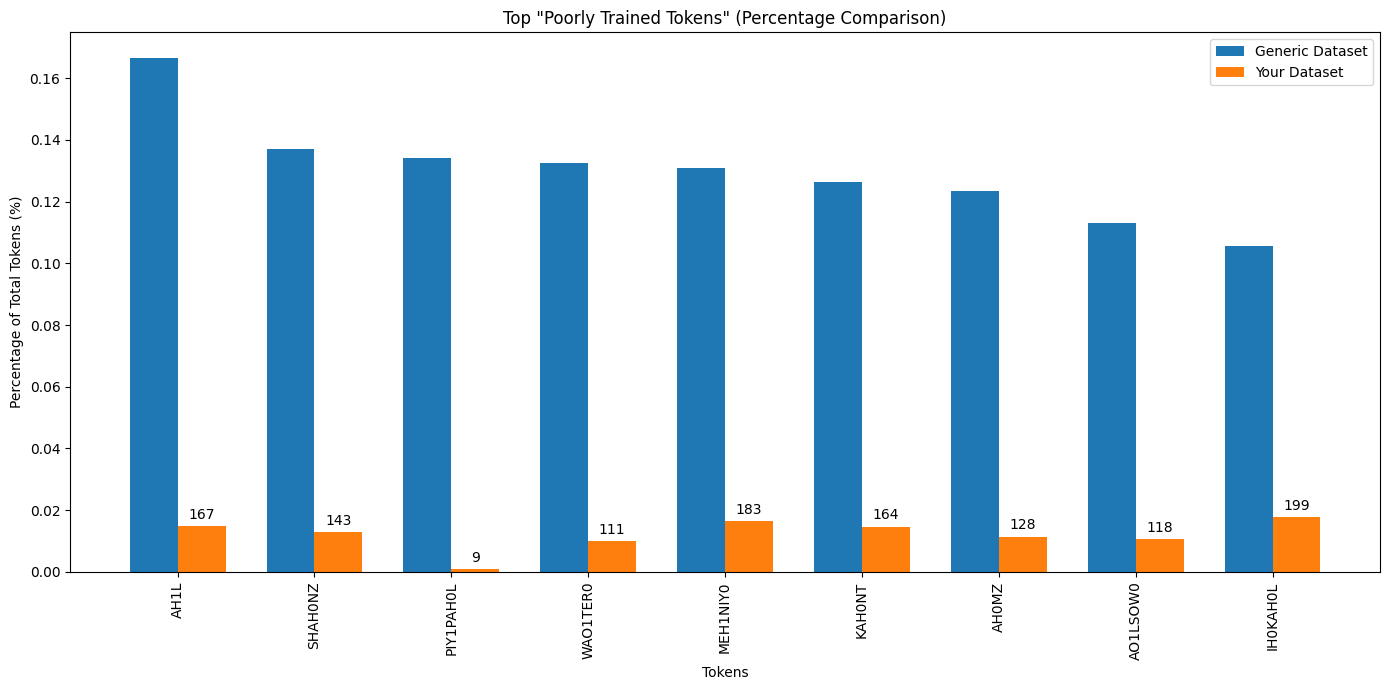

In [22]:
## Visualize 'Poorly Trained Tokens'

# Prepare data for visualization
tokens_poorly_trained = [id_to_token[token_id] for token_id in poorly_trained_tokens.keys()]
generic_percentages_poorly_trained = [values[0] for values in poorly_trained_tokens.values()]
dataset_percentages_poorly_trained = [values[1] for values in poorly_trained_tokens.values()]
dataset_counts_poorly_trained = [dataset_token_counts.get(token_id, 0) for token_id in poorly_trained_tokens.keys()]

# Sort tokens by generic percentages descending
tokens_data_poorly_trained = sorted(
    zip(tokens_poorly_trained, generic_percentages_poorly_trained, dataset_percentages_poorly_trained, dataset_counts_poorly_trained),
    key=lambda x: -x[1]
)
tokens_poorly_trained, generic_percentages_poorly_trained, dataset_percentages_poorly_trained, dataset_counts_poorly_trained = zip(*tokens_data_poorly_trained)

# Limit number of tokens for visualization
top_n_poorly_trained = 50  # Adjust as needed
tokens_poorly_trained = tokens_poorly_trained[:top_n_poorly_trained]
generic_percentages_poorly_trained = generic_percentages_poorly_trained[:top_n_poorly_trained]
dataset_percentages_poorly_trained = dataset_percentages_poorly_trained[:top_n_poorly_trained]
dataset_counts_poorly_trained = dataset_counts_poorly_trained[:top_n_poorly_trained]

# Plotting 'Poorly Trained Tokens'
x = np.arange(len(tokens_poorly_trained))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 7))
rects1 = ax.bar(x - width/2, generic_percentages_poorly_trained, width, label='Generic Dataset')
rects2 = ax.bar(x + width/2, dataset_percentages_poorly_trained, width, label='Your Dataset')

# Add labels and title
ax.set_xlabel('Tokens')
ax.set_ylabel('Percentage of Total Tokens (%)')
ax.set_title(f'Top "Poorly Trained Tokens" (Percentage Comparison)')
ax.set_xticks(x)
ax.set_xticklabels(tokens_poorly_trained, rotation=90)
ax.legend()

# Annotate the 'Your Dataset' bars with the absolute counts from your dataset
for rect, count in zip(rects2, dataset_counts_poorly_trained):
    height = rect.get_height()
    ax.annotate(f'{count}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # Offset text by 3 points vertically
                textcoords="offset points",
                ha='center', va='bottom')

fig.tight_layout()
plt.show()


In [25]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
from tokenizers import Tokenizer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.models import BPE

# Assuming the following are already defined:
# - dataset_token_counts
# - generic_token_counts
# - id_to_token
# - tokenizer

### Step 1: Identify "Poorly Trained" and "Useless" Tokens

# Thresholds
generic_threshold = 10  # For "useless" tokens
generic_common_threshold = 500  # For "poorly trained" tokens (common in generic)
dataset_uncommon_threshold = 50  # For "poorly trained" tokens (uncommon in dataset)

# Identify "useless" tokens (uncommon in generic dataset)
useless_tokens = {
    token_id for token_id, count in generic_token_counts.items() if count < generic_threshold
}

# Identify "poorly trained" tokens (common in generic but uncommon in dataset)
poorly_trained_tokens = {
    token_id for token_id, generic_count in generic_token_counts.items()
    if generic_count > generic_common_threshold and dataset_token_counts.get(token_id, 0) < dataset_uncommon_threshold
}

# Combine "useless" and "poorly trained" tokens
combined_tokens = useless_tokens.union(poorly_trained_tokens)

### Step 2: Check if Splitting Tokens Results in Sub-Tokens That Are Neither "Poorly Trained" Nor "Useless"

# Prepare sets for faster lookup
poorly_trained_or_useless_tokens = useless_tokens.union(poorly_trained_tokens) - ignore_tokens

# Initialize list to collect tokens that meet the criteria
tokens_to_split = []

# Create BPE tokenizers that ignore certain tokens
def create_subtokenizer(remove_tokens):
    subvocab = {k: v for k,v in tokenizer.vocab.items() if k not in remove_tokens}
    submerges = [tuple(x.split(' ')) for x in merges if ''.join(x.split(' ')) not in remove_tokens]
    subtokenizer_model = BPE(vocab=subvocab, merges=submerges, unk_token=tokenizer.unk_token)
    subtokenizer = Tokenizer(subtokenizer_model)
    subtokenizer.pre_tokenizer = Whitespace()
    return subtokenizer


# Iterate over combined tokens
for token_id in combined_tokens:
    token_str = id_to_token[token_id]
    # Encode the token string using the tokenizer
    try:
        subtokenizer = create_subtokenizer({token_str})
        encoded_token_strs = subtokenizer.encode(token_str, add_special_tokens=False).tokens
        encoded_token_ids = [tokenizer.vocab[x] for x in encoded_token_strs]
    except:
        continue
    
    if any(tok == tokenizer.unk_token for tok in encoded_token_strs):
        continue

    # Check if the token splits into multiple tokens and is different from the original token
    if len(encoded_token_ids) > 1 or encoded_token_ids[0] != token_id:
        # Check if all sub-tokens are neither poorly trained nor useless
        all_subtokens_good = True
        for subtoken_id in encoded_token_ids:
            if subtoken_id in poorly_trained_or_useless_tokens:
                all_subtokens_good = False
                break
        if all_subtokens_good:
            tokens_to_split.append({
                'original_token': token_str,
                'original_token_id': token_id,
                'subtokens': [id_to_token[stid] for stid in encoded_token_ids],
                'subtoken_ids': encoded_token_ids,
                'original_count_dataset': dataset_token_counts.get(token_id, 0),
                'original_count_generic': generic_token_counts.get(token_id, 0),
            })
        else:
            print('Failed to split', token_str, 'into good tokens')

### Step 3: Output the Tokens That Meet the Criteria

# Print the results
print(f"Tokens that are poorly trained or useless and can be split into better sub-tokens ({len(tokens_to_split)} tokens):\n")
for item in tokens_to_split:
    print(f"Original Token: '{item['original_token']}'")
    print(f"  Token ID: {item['original_token_id']}")
    print(f"  Counts - Dataset: {item['original_count_dataset']}, Generic: {item['original_count_generic']}")
    print(f"  Sub-Tokens: {item['subtokens']}")
    print(f"  Sub-Token IDs: {item['subtoken_ids']}")
    print()


Tokens that are poorly trained or useless and can be split into better sub-tokens (6 tokens):

Original Token: 'PLAE1NTS'
  Token ID: 332
  Counts - Dataset: 13, Generic: 4875
  Sub-Tokens: ['PLAE1N', 'TS']
  Sub-Token IDs: [244, 76]

Original Token: 'IH2Z'
  Token ID: 344
  Counts - Dataset: 25, Generic: 4693
  Sub-Tokens: ['IH2', 'Z']
  Sub-Token IDs: [121, 37]

Original Token: 'PRAH0D'
  Token ID: 296
  Counts - Dataset: 8, Generic: 3741
  Sub-Tokens: ['PR', 'AH0D']
  Sub-Token IDs: [87, 101]

Original Token: 'PIY1PAH0L'
  Token ID: 248
  Counts - Dataset: 9, Generic: 7298
  Sub-Tokens: ['PIY1', 'PAH0L']
  Sub-Token IDs: [227, 181]

Original Token: 'HHYUW1MAH0N'
  Token ID: 377
  Counts - Dataset: 0, Generic: 4076
  Sub-Tokens: ['HHYUW1', 'MAH0N']
  Sub-Token IDs: [352, 141]

Original Token: 'DHIH1S'
  Token ID: 380
  Counts - Dataset: 4155, Generic: 0
  Sub-Tokens: ['DH', 'IH1S']
  Sub-Token IDs: [57, 231]

